<a href="https://colab.research.google.com/github/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/(On_Google_Colab)_With_Hit_Scoring_TF_MoDISco_TAL_GATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-MoDISco on the TAL GATA simulation

### Note: we are still refining the multi-task version of TF-MoDISco. If you encounter difficulties running TF-MoDISco with multiple tasks, our recommendation is to run it on one task at a time.

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See Generate Importance Scores.ipynb for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [13]:
!pip install modisco

In [0]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [15]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


## Grab the input data

In [0]:
#grab scores for tfmodisco
#!/usr/bin/env bash
![[ -f scores.h5 ]] || curl -o scores.h5 https://raw.githubusercontent.com/AvantiShri/model_storage/23d8f3ffc89af210f6f0bf7e65585eff259ba672/modisco/scores.h5
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

## Functions for one-hot encoding sequences¶

In [0]:
#Functions for one-hot encoding sequences
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [0]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100 #since this is just a test run, for speed I am limiting to 100 sequences
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

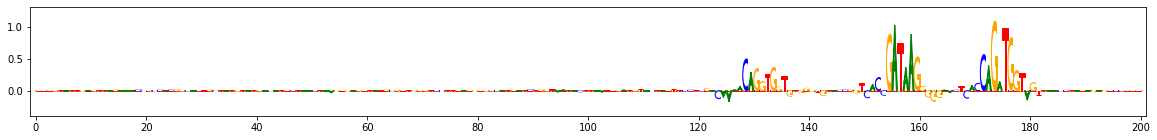

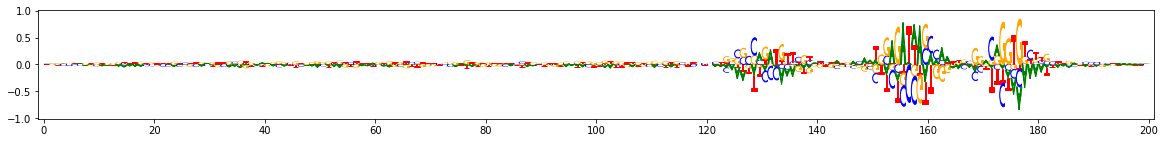

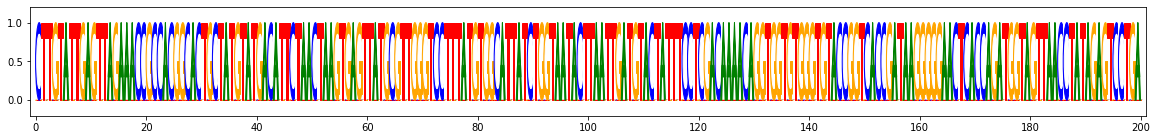

In [19]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=20)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=20)

Run TF-MoDISco
TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:

- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance. trim_to_window_size is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add. This is set to 3 rather than the default of 10.
- The final_min_cluster_size is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, which tends to run out of memory on many systems (I would change the default but want to avoid breaking reproducibility for older users)
- target_seqlet_fdr controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size sliding_window_size and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that target_seqlet_fdr. Note: if the number of sliding windows that pass the FDR threshold is smaller than min_passing_windows_frac (default value 0.03 at the time of writing) or larger than max_passing_windows_frac (default value of 0.2 at the time of writing), the threshold will be adjusted.

MEMORY 0.49606656
On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Computing threshold
Thresholds from null dist were -1.0124836564064026  and  0.8997364044189453
Final raw thresholds are -1.0124836564064026  and  0.8997364044189453
Final transformed thresholds are -0.8494086021505376  and  0.8402150537634409


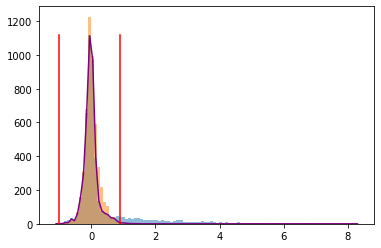

Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Computing threshold
Thresholds from null dist were -0.918197512626648  and  0.608733057975769
Final raw thresholds are -0.918197512626648  and  0.608733057975769
Final transformed thresholds are -0.9040322580645161  and  0.8833870967741936


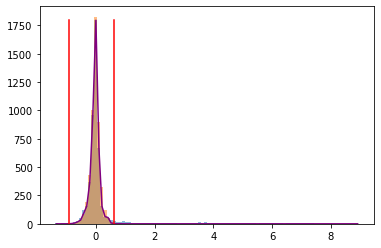

Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Computing threshold
Thresholds from null dist were -0.6213091909885406  and  0.6281718015670776
Final raw thresholds are -0.6213091909885406  and  0.6281718015670776
Final transformed thresholds are -0.8680107526881721  and  0.8682795698924731


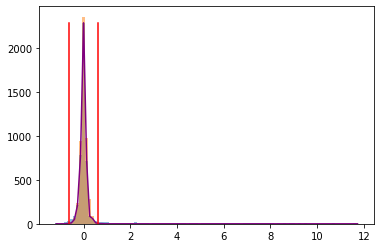

Got 166 coords
After resolving overlaps, got 275 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8402149537634409
MEMORY 0.498741248
275 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [115, 104]
Idx to activities:  {0: '1,0,1', 1: '1,1,0'}
MEMORY 0.498741248
On metacluster 1
Metacluster size 104
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 104
(Round 1) Computing coarse affmat
MEMORY 0.49707008
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.06 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.02 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.500494336
Computed nearest neighbors in 0.0 s

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    8.6s


Louvain completed 200 runs in 10.873558521270752 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.8s finished


Wrote graph to binary file in 0.01034998893737793 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.682054
After 8 runs, maximum modularity is Q = 0.705021
Louvain completed 58 runs in 0.8735165596008301 seconds
Preproc + Louvain took 11.80029010772705 s
Got 7 clusters after round 1
Counts:
{6: 5, 2: 16, 1: 16, 4: 12, 0: 25, 3: 15, 5: 9}
MEMORY 0.50581504
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.50581504
Aggregating for cluster 0 with 25 seqlets
MEMORY 0.50581504
Trimmed 0 out of 25
Skipped 6 seqlets
Aggregating for cluster 1 with 16 seqlets
MEMORY 0.50581504
Trimmed 0 out of 16
Skipped 1 seqlets
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.50581504
Trimmed 1 out of 16
Aggregating for cluster 3 with 15 seqlets
MEMORY 0.50581504
Trimmed 0 out of 15
Skipped 2 seqlets
Aggregating for cluster 4 with 12 seqlets
MEMORY 0.50581504
Trimmed 0 out of 12
Skipped 2 seqlets
Aggregating for cluster 5 with 9 seqlets
MEMORY 0.50581504
Trimmed

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    8.6s


Louvain completed 200 runs in 12.051777124404907 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.8s finished


Wrote graph to binary file in 0.007441997528076172 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.749593
Louvain completed 51 runs in 0.7588787078857422 seconds
Preproc + Louvain took 12.857669115066528 s
Got 9 clusters after round 2
Counts:
{5: 10, 0: 16, 6: 8, 1: 15, 8: 2, 2: 12, 3: 11, 4: 10, 7: 2}
MEMORY 0.505860096
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.505860096
Aggregating for cluster 0 with 16 seqlets
MEMORY 0.505860096
Trimmed 0 out of 16
Aggregating for cluster 1 with 15 seqlets
MEMORY 0.505860096
Trimmed 1 out of 15
Aggregating for cluster 2 with 12 seqlets
MEMORY 0.505860096
Trimmed 1 out of 12
Aggregating for cluster 3 with 11 seqlets
MEMORY 0.505860096
Trimmed 0 out of 11
Aggregating for cluster 4 with 10 seqlets
MEMORY 0.505860096
Trimmed 0 out of 10
Aggregating for cluster 5 with 10 seqlets
MEMORY 0.505860096
Trimmed 2 out of 10
Aggregating for cluster 6 with 8 seqlets
MEMORY 0.505860096
Trimmed 0 out of 8
Aggre

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    8.6s


Louvain completed 200 runs in 12.106160163879395 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.9s finished


Wrote graph to binary file in 0.012551069259643555 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.687359
After 2 runs, maximum modularity is Q = 0.703726
After 3 runs, maximum modularity is Q = 0.710767
After 4 runs, maximum modularity is Q = 0.711377
After 20 runs, maximum modularity is Q = 0.712564
Louvain completed 70 runs in 1.076392650604248 seconds
Preproc + Louvain took 13.234612941741943 s
Got 6 clusters after round 1
Counts:
{4: 16, 2: 23, 3: 17, 1: 25, 0: 25, 5: 3}
MEMORY 0.510984192
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.510984192
Aggregating for cluster 0 with 25 seqlets
MEMORY 0.510984192
Trimmed 0 out of 25
Skipped 7 seqlets
Aggregating for cluster 1 with 25 seqlets
MEMORY 0.510984192
Trimmed 0 out of 25
Skipped 3 seqlets
Aggregating for cluster 2 with 23 seqlets
MEMORY 0.510984192
Trimmed 3 out of 23
Skipped 3 seqlets
Aggregating for cluster 3 with 17 seqlets
MEMORY 0.510984192
Trimmed 0 out of 17
Skipped 2 seqle

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    8.7s


Louvain completed 200 runs in 12.060325860977173 seconds


[Parallel(n_jobs=4)]: Done 193 out of 200 | elapsed:   10.7s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   10.8s finished


Wrote graph to binary file in 0.009551286697387695 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.74306
Louvain completed 51 runs in 0.7689599990844727 seconds
Preproc + Louvain took 12.877119779586792 s
Got 6 clusters after round 2
Counts:
{0: 19, 3: 16, 2: 16, 4: 14, 1: 16, 5: 7}
MEMORY 0.510984192
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.510984192
Aggregating for cluster 0 with 19 seqlets
MEMORY 0.510984192
Trimmed 3 out of 19
Aggregating for cluster 1 with 16 seqlets
MEMORY 0.510984192
Trimmed 0 out of 16
Aggregating for cluster 2 with 16 seqlets
MEMORY 0.510984192
Trimmed 0 out of 16
Aggregating for cluster 3 with 16 seqlets
MEMORY 0.510984192
Trimmed 0 out of 16
Aggregating for cluster 4 with 14 seqlets
MEMORY 0.510984192
Trimmed 0 out of 14
Aggregating for cluster 5 with 7 seqlets
MEMORY 0.510984192
Trimmed 0 out of 7
Got 6 clusters
Splitting into subclusters...
MEMORY 0.510984192
Merging on 6 clusters
MEMORY 0.510984192
O

In [20]:
import h5py
import numpy as np
%matplotlib inline
import modisco

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                 task_names=["task0", "task1", "task2"],
                 contrib_scores=task_to_scores,
                 hypothetical_contribs=task_to_hyp_scores,
                 one_hot=onehot_data,
                 null_per_pos_scores = null_per_pos_scores)

## Save Results

In [0]:
import h5py
import modisco.util
reload(modisco.util)
![[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results directly from hdf5

Metaclusters heatmap


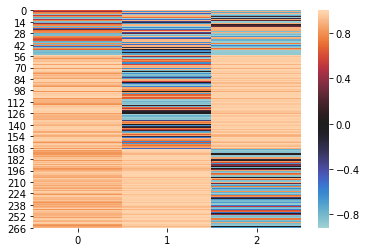

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 82
Task 0 hypothetical scores:


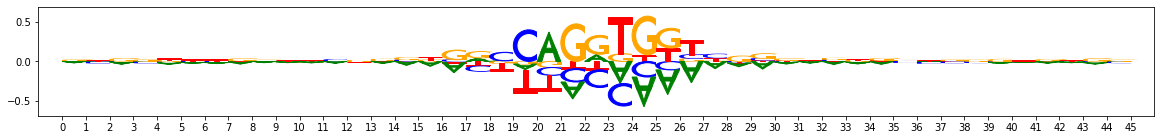

Task 0 actual importance scores:


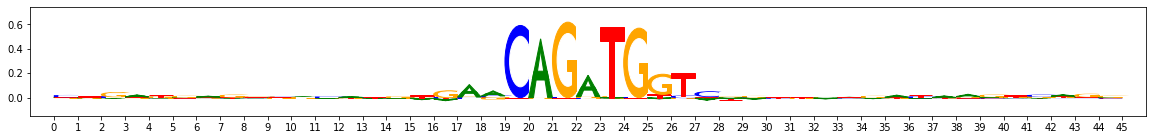

Task 1 hypothetical scores:


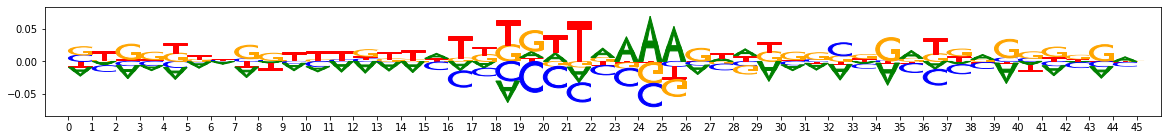

Task 1 actual importance scores:


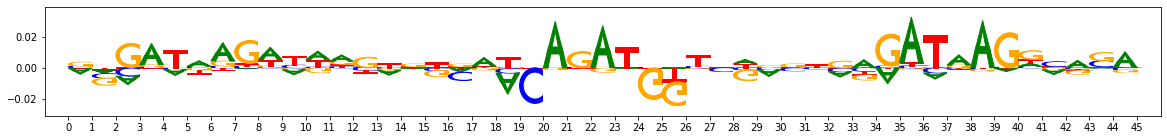

Task 2 hypothetical scores:


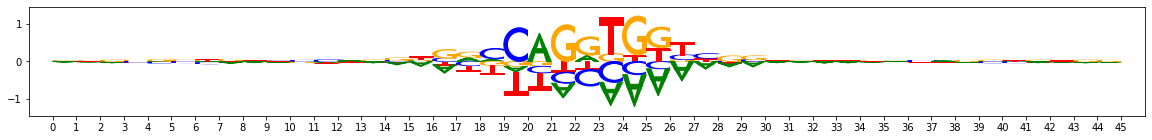

Task 2 actual importance scores:


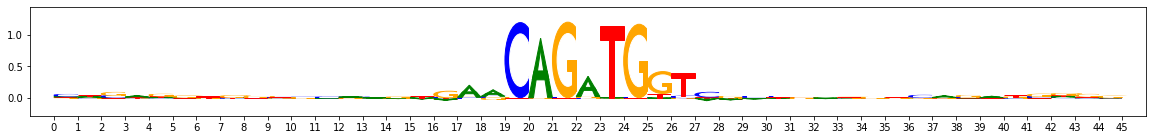

onehot, fwd and rev:


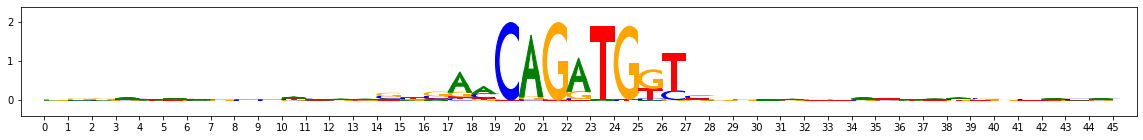

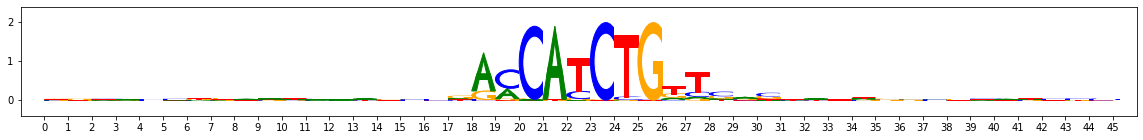

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 71
Task 0 hypothetical scores:


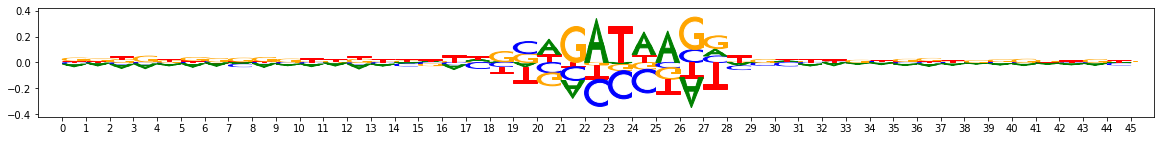

Task 0 actual importance scores:


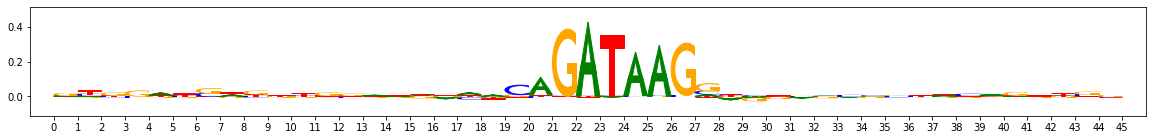

Task 1 hypothetical scores:


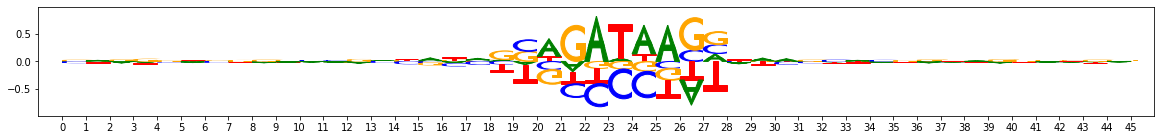

Task 1 actual importance scores:


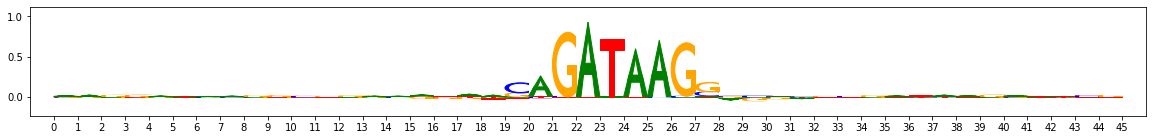

Task 2 hypothetical scores:


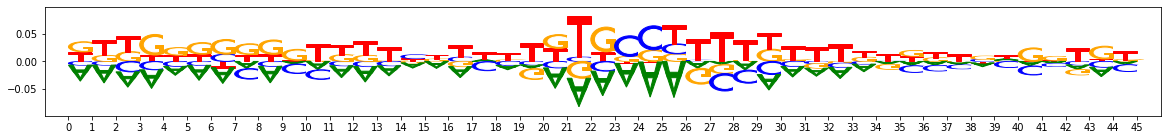

Task 2 actual importance scores:


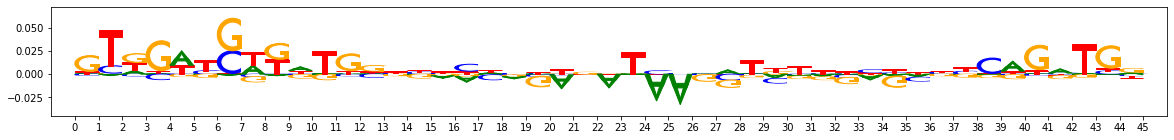

onehot, fwd and rev:


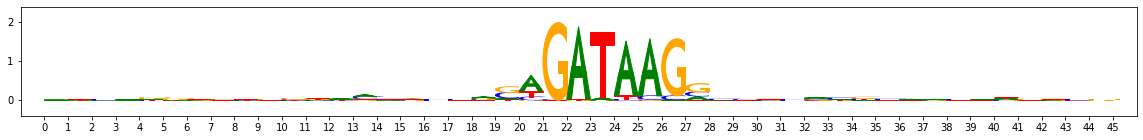

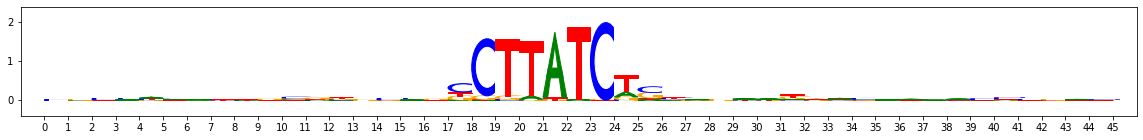

In [22]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file
Load the results object from the saved file

In [0]:
import h5py
import numpy as np
import modisco
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

## Prepare hit scorers
Prepare a seqlet scorer (max_rank_based_pattern_scorer); note, the best seqlet scoring strategy is still being explored

In [0]:
from collections import OrderedDict

from modisco import affinitymat
reload(affinitymat.core)
reload(affinitymat)
from modisco import hit_scoring
reload(hit_scoring.fast_hit_scoring)
reload(hit_scoring)
from collections import OrderedDict

task_names = ["task0", "task1", "task2"]

seqlet_size_to_score_with = 25

metacluster_idx_to_scorer = OrderedDict()

all_pattern_scorers = []
all_pattern_names = []

for metacluster_name in\
    sorted(loaded_tfmodisco_results
           .metacluster_idx_to_submetacluster_results.keys()):
    submetacluster_results =(
        loaded_tfmodisco_results
            .metacluster_idx_to_submetacluster_results[metacluster_name])
    activity_pattern = submetacluster_results.activity_pattern
    relevant_task_names = [task_name for (task_name,x) in
                           zip(task_names, activity_pattern) if np.abs(x) != 0]
    
    patterns_in_submetacluster =\
        submetacluster_results.seqlets_to_patterns_result.patterns
 
    pattern_comparison_settings = affinitymat.core.PatternComparisonSettings(
        track_names=([x+"_contrib_scores" for x in relevant_task_names]
                     +[x+"_hypothetical_contribs" for x in relevant_task_names]),
        track_transformer=affinitymat.L1Normalizer(),
        min_overlap=0.7)

    pattern_to_seqlets_sim_computer = hit_scoring.PatternsToSeqletsSimComputer(
        pattern_comparison_settings=pattern_comparison_settings,
        cross_metric_computer=\
            affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=1,
                cross_metric_single_region=
                    affinitymat.core.CrossContinJaccardSingleRegionWithArgmax(),
                verbose=False),
        seqlet_trimmer=modisco.hit_scoring.SeqletTrimToBestWindow(
                        window_size=seqlet_size_to_score_with,
                        track_names=[x+"_contrib_scores" for x
                                     in relevant_task_names]))

    #Get a list of scorers for all the patterns in the metacluster
    metacluster_pattern_scorers = []
    for pattern_idx, pattern in\
        enumerate(submetacluster_results.
                   seqlets_to_patterns_result.patterns):
        metacluster_idx = int(metacluster_name.split("_")[1])
        all_pattern_names.append("metacluster_"+str(metacluster_idx)
                             +",pattern_"+str(pattern_idx))
        pattern_scorer = hit_scoring.RankBasedPatternScorer(
                aggseqlets=pattern,
                patterns_to_seqlets_sim_computer=
                    pattern_to_seqlets_sim_computer)
        metacluster_pattern_scorers.append(pattern_scorer)
        all_pattern_scorers.append(pattern_scorer)
    #This is the final scorer for the metacluster;
    # it takes the maximum score produced by all the
    # individual scorers
    max_rank_based_pattern_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                        pattern_scorers=metacluster_pattern_scorers)
    metacluster_idx_to_scorer[metacluster_idx] = max_rank_based_pattern_scorer
cross_metacluster_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                pattern_scorers=all_pattern_scorers)


Test it out...prepare a bunch of seqlets to score using the original patterns

In [0]:
from sklearn.metrics import confusion_matrix
all_patterns = [x for y in
                  sorted(loaded_tfmodisco_results
                  .metacluster_idx_to_submetacluster_results.keys())
                  for x in
                   loaded_tfmodisco_results
                   .metacluster_idx_to_submetacluster_results[y]
                   .seqlets_to_patterns_result.patterns]
seqlets_to_score = []
seqlets_to_score_true_labels = []
for i,pattern in enumerate(all_patterns):
    seqlets_to_score.extend(pattern.seqlets)
    seqlets_to_score_true_labels.extend(
        [i for x in pattern.seqlets])



Now score the seqlets (we will use the cross-metacluster scorer here)

In [26]:
pattern_scores_for_each_seqlet = cross_metacluster_scorer(seqlets_to_score)
print(pattern_scores_for_each_seqlet[:5])
seqlets_to_score_predicted_labels =\
    [x.pattern_idx for x in pattern_scores_for_each_seqlet]
confusion_mat = confusion_matrix(y_true = seqlets_to_score_true_labels,
                                 y_pred = seqlets_to_score_predicted_labels)
print(all_pattern_names)
print(confusion_mat.astype("float")/np.sum(confusion_mat,axis=1)[:,None])

[RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9512195121951219, score=0.6312267278280181, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.36585365853658536, score=0.48199815813829505, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.8292682926829268, score=0.6045231291385648, offset=0.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=1, percnormed_score=0.49295774647887325, score=0.49037363694112757, offset=19.0, revcomp=0.0), RankNormedScoreResults(pattern_idx=0, percnormed_score=0.6341463414634146, score=0.5535650315103232, offset=0.0, revcomp=0.0)]
['metacluster_0,pattern_0', 'metacluster_1,pattern_0']
[[0.97560976 0.02439024]
 [0.02816901 0.97183099]]


## Obtain seqlets from data

In [27]:
per_position_contrib_scores = OrderedDict([                             
    (x, [np.sum(s,axis=1) for s in task_to_scores[x]]) for x in tasks])
seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track=per_position_contrib_scores,  
        null_tracks=null_per_pos_scores,
        track_set=track_set,
        task_name_to_tnt_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_tnt_results,
        )).final_seqlets

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02237087196292123
Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.00025505211204290357
Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= -0.001713569819345139
Got 166 coords
After resolving overlaps, got 275 seqlets


## Map seqlets to metacluster, then to a pattern

Example seqlets for metacluster -1 (unmapped)


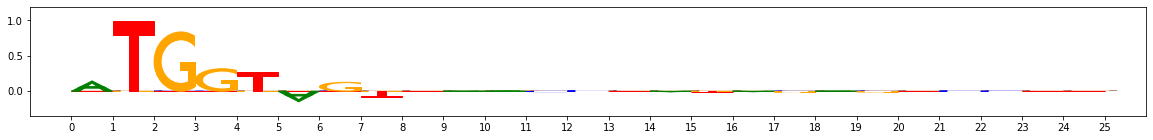

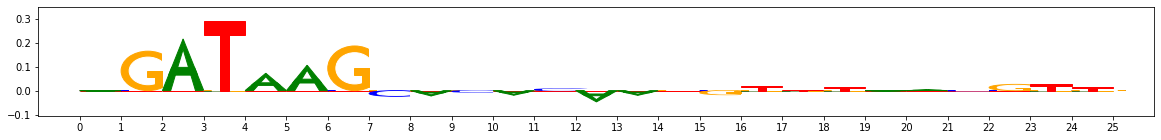


Metacluster idx 0 

TOP MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=1.0, score=0.648643707267138, offset=12.0, revcomp=0.0)


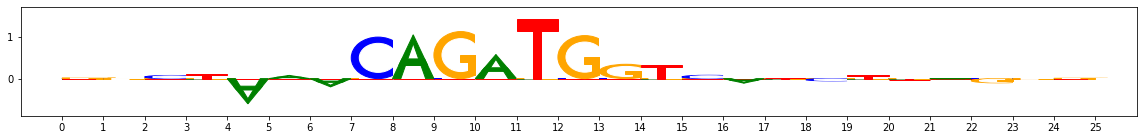

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9878048780487805, score=0.646410718918468, offset=7.0, revcomp=0.0)


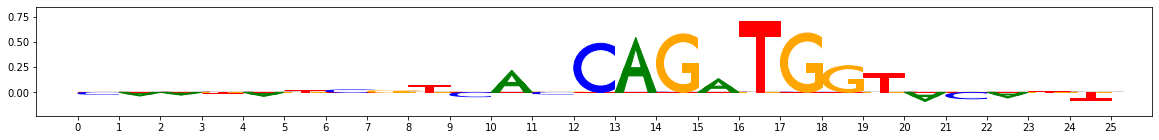

WORST MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=0.0, score=0.1666957540495901, offset=9.0, revcomp=0.0)


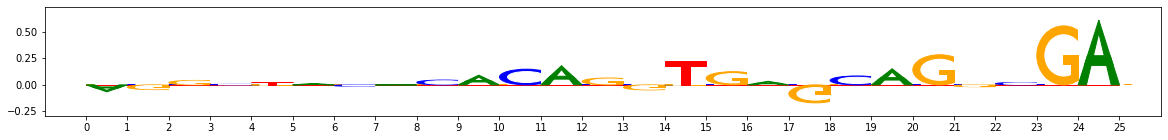

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.012195121951219513, score=0.2568686083950155, offset=9.0, revcomp=0.0)


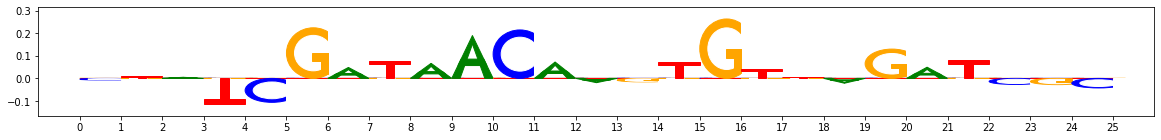


Metacluster idx 1 

TOP MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=1.0, score=0.6294100096606345, offset=14.0, revcomp=0.0)


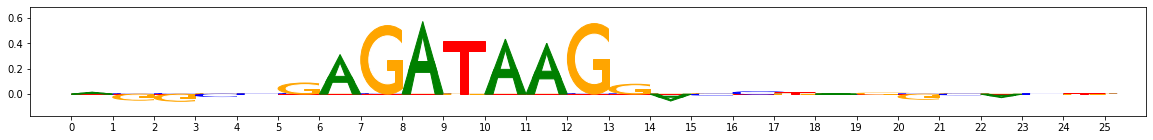

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.9859154929577465, score=0.6212164433721763, offset=8.0, revcomp=0.0)


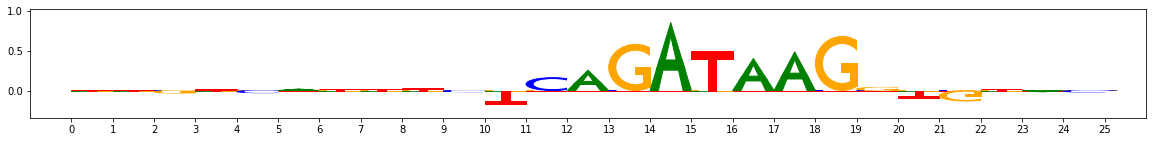

WORST MATCHES
RankNormedScoreResults(pattern_idx=0, percnormed_score=0.028169014084507043, score=0.23939403455875027, offset=8.0, revcomp=0.0)


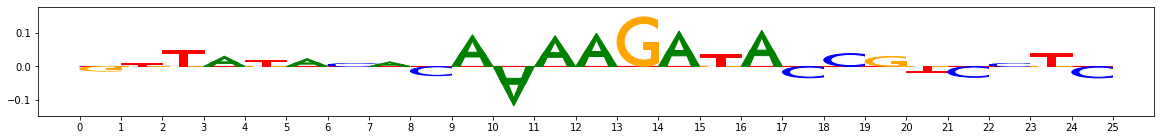

RankNormedScoreResults(pattern_idx=0, percnormed_score=0.028169014084507043, score=0.21646523004965437, offset=22.0, revcomp=0.0)


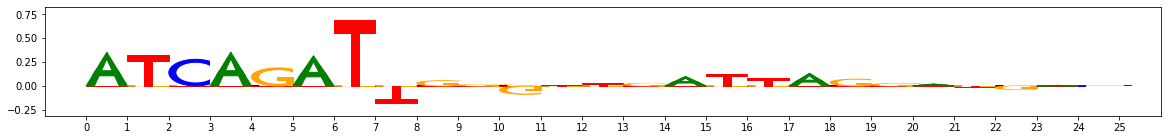

In [28]:
from collections import defaultdict, OrderedDict

metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    seqlets_from_data).metacluster_indices

metacluster_idx_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(seqlets_from_data, metacluster_indices):
    metacluster_idx_to_seqlets[metacluster_idx].append(a_seqlet)

#visualize a few seqlets from each metacluster
num_to_viz = 2
for metacluster_idx in metacluster_idx_to_seqlets:
    if (metacluster_idx == -1):
        print("Example seqlets for metacluster -1 (unmapped)")
        for a_seqlet in metacluster_idx_to_seqlets[metacluster_idx][:num_to_viz]:
            viz_sequence.plot_weights(a_seqlet["task0_contrib_scores"].fwd)

#map to patterns within each metacluster
metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    print("\nMetacluster idx",metacluster_idx,"\n")
    metacluster_seqlets = metacluster_idx_to_seqlets[metacluster_idx]
    seqlet_pattern_matches = metacluster_idx_to_scorer[metacluster_idx](metacluster_seqlets)
    metacluster_to_seqlet_pattern_matches[metacluster_idx] = seqlet_pattern_matches
    sorted_seqlet_pattern_matches = sorted(zip(seqlet_pattern_matches, metacluster_seqlets),
                                           key=lambda x: -x[0].percnormed_score)
    print("TOP MATCHES")
    for i in range(num_to_viz):
        print(sorted_seqlet_pattern_matches[i][0])
        viz_sequence.plot_weights(sorted_seqlet_pattern_matches[i][1]["task0_contrib_scores"].fwd)
    print("WORST MATCHES")
    for i in range(num_to_viz):
        print(sorted_seqlet_pattern_matches[-(i+1)][0])
        viz_sequence.plot_weights(sorted_seqlet_pattern_matches[-(i+1)][1]["task0_contrib_scores"].fwd)

The code below is a test to check that reverse complements also work

In [29]:
#The rc_track_set and rc_seqlets_from_data is just there to
# test whether reverse complements are working correctly
rc_track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=dict([(key, np.array(val)[:,::-1,::-1]) for
                                     (key,val) in task_to_scores.items()]),
                hypothetical_contribs=dict([(key, np.array(val)[:,::-1,::-1]) for
                                            (key,val) in task_to_hyp_scores.items()]),
                one_hot=onehot_data)
rc_seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track={key: np.array(val)[:,::-1] for
                                  (key,val) in per_position_contrib_scores.items()},
        null_tracks=null_per_pos_scores,
        track_set=rc_track_set,
        task_name_to_tnt_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_tnt_results)).final_seqlets

rc_metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    rc_seqlets_from_data).metacluster_indices
assert np.max(np.abs(np.array(rc_metacluster_indices)
                     - np.array(metacluster_indices)))==0

rc_metacluster_idx_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(rc_seqlets_from_data, rc_metacluster_indices):
    rc_metacluster_idx_to_seqlets[metacluster_idx].append(a_seqlet)

#map to patterns within each metacluster
rc_metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    rc_metacluster_to_seqlet_pattern_matches[metacluster_idx] =\
        metacluster_idx_to_scorer[metacluster_idx](rc_metacluster_idx_to_seqlets[metacluster_idx])
        
#check that the scores are compatible
for metacluster_idx in rc_metacluster_to_seqlet_pattern_matches:
    rc_seqlet_pattern_matches = rc_metacluster_to_seqlet_pattern_matches[metacluster_idx]
    seqlet_pattern_matches = metacluster_to_seqlet_pattern_matches[metacluster_idx]
    for (rc_match, fwd_match) in zip(rc_seqlet_pattern_matches, seqlet_pattern_matches):
        #atol = 0.02 because small numerical differences in the match score
        # can shif the percentile ranking around
        if (np.isclose(rc_match.percnormed_score,fwd_match.percnormed_score,atol=0.02) == False):
            print(rc_match, fwd_match)
            assert False
        assert np.isclose(rc_match.score, fwd_match.score)
        #In the revcomp case,
        # the value of the offset would be the same as the fwd's distance
        # from the end of the seqlet to the end of the pattern.
        # At the time of writing, 45 bp was the length of the pattern and
        # 25 bp was the length of the seqlet; 45 - (offset + 25) = 20-offset
        assert rc_match.offset == 20-fwd_match.offset
        assert rc_match.revcomp == 1.0
        assert fwd_match.revcomp == 0.0

On task task0
Computing windowed sums on original
Generating null dist
peak(mu)= -0.02277598714828491
Got 198 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= -0.0002551083639264107
Got 145 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= 0.006824198871850967
Got 166 coords
After resolving overlaps, got 275 seqlets
